In [ ]:
import pandas as pd
from google.cloud import bigquery
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import os
from dotenv import load_dotenv

load_dotenv()
PROJECT_ID = os.getenv('GCP_PROJECT_ID')
DATASET_ID = os.getenv('BIGQUERY_DATASET_ID')
client = bigquery.Client()

In [2]:
query = """
SELECT
    counts.pitcher_name,
    counts.pitcher_id,
    counts.game_pk,
    2025 as game_year,
    counts.inning,

    -- 投球カウント
    counts.total_pitches,
    counts.total_strikes,
    counts.total_balls,
    counts.strike_rate,
    counts.ball_rate,

    -- Fastballのみの球速
    quality.avg_release_speed as fastball_speed,
    quality.avg_spin_rate as fastball_spin,

    -- パフォーマンス指標
    perf.ops_against,
    perf.batting_average_against,
    perf.home_runs_allowed,
    perf.hits_allowed,
    perf.free_passes

FROM `{PROJECT_ID}.{DATASET_ID}.view_pitching_counts_by_inning_2025` as counts
LEFT JOIN `{PROJECT_ID}.{DATASET_ID}.view_pitch_type_quality_by_inning_2025` as quality
    ON counts.pitcher_id = quality.pitcher_id
    AND counts.game_pk = quality.game_pk
    AND counts.inning = quality.inning
    AND quality.pitch_name IN ('4-Seam Fastball', 'Fastball')
LEFT JOIN `{PROJECT_ID}.{DATASET_ID}.tbl_pitching_performance_by_inning` as perf
    ON counts.pitcher_id = perf.pitcher_id
    AND counts.inning = perf.inning
    AND perf.game_year = 2025
WHERE quality.pitch_name IN ('4-Seam Fastball', 'Fastball')
ORDER BY counts.pitcher_name, counts.game_pk, counts.inning
"""

df = client.query(query).to_dataframe()
print(f"Total records: {df.shape[0]}")
print(f"Unique pitchers: {df['pitcher_name'].nunique()}")
print(f"Unique games: {df['game_pk'].nunique()}")
df.head()

c:\Users\inthe\Desktop\Python_scripts_2025\diamond-lens\venv\Lib\site-packages\google\cloud\bigquery\table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


Total records: 677511
Unique pitchers: 755
Unique games: 2459


,pitcher_name,pitcher_id,game_pk,game_year,inning,total_pitches,total_strikes,total_balls,strike_rate,ball_rate,fastball_speed,fastball_spin,ops_against,batting_average_against,home_runs_allowed,hits_allowed,free_passes
0,"Abbott, Andrew",671096,776153,2025,1,18,7,7,0.389,0.389,93.29,2346.2,0.250,0.000,0,0,1
1,"Abbott, Andrew",671096,776153,2025,1,18,7,7,0.389,0.389,93.29,2346.2,0.500,0.250,0,1,0
2,"Abbott, Andrew",671096,776153,2025,1,18,7,7,0.389,0.389,93.29,2346.2,1.905,0.667,1,4,0
3,"Abbott, Andrew",671096,776153,2025,1,18,7,7,0.389,0.389,93.29,2346.2,0.000,0.000,0,0,0
4,"Abbott, Andrew",671096,776153,2025,1,18,7,7,0.389,0.389,93.29,2346.2,0.250,0.000,0,0,1


In [3]:
# ゲームごとのcumulative pitchesを計算
df = df.sort_values(['pitcher_id', 'game_pk', 'inning'])
df['cumulative_pitches_per_game'] = df.groupby(['pitcher_id', 'game_pk'])['total_pitches'].cumsum()

# 各投手の初回（1イニング目）のベースライン指標を取得（ゲーム別の平均）
pitcher_baseline = df[df['inning'] == 1].groupby('pitcher_id').agg({
    'fastball_speed': 'mean',
    'fastball_spin': 'mean',
    'ops_against': 'mean',
    'strike_rate': 'mean'
}).rename(columns={
    'fastball_speed': 'baseline_fastball_speed',
    'fastball_spin': 'baseline_fastball_spin',
    'ops_against': 'baseline_ops_against',
    'strike_rate': 'baseline_strike_rate'
})

# ベースライン指標を元のデータフレームにマージ
df = df.merge(pitcher_baseline, on='pitcher_id', how='left')

# イニングごとの平均累積投球数を計算
avg_cumulative_by_inning = df.groupby(['pitcher_id', 'inning'])['cumulative_pitches_per_game'].mean().reset_index()
avg_cumulative_by_inning.rename(columns={'cumulative_pitches_per_game': 'cumulative_pitches'}, inplace=True)

# 元のデータフレームにマージ
df = df.drop(columns=['cumulative_pitches_per_game'])
df = df.merge(avg_cumulative_by_inning, on=['pitcher_id', 'inning'], how='left')

# Calculate fatigue metrics
df['speed_drop'] = df['baseline_fastball_speed'] - df['fastball_speed']
df['spin_drop'] = df['baseline_fastball_spin'] - df['fastball_spin']
df['ops_increase'] = df['ops_against'] - df['baseline_ops_against']
df['strike_rate_drop'] = df['baseline_strike_rate'] - df['strike_rate']

print("Columns in df:", df.columns.tolist())
print("\nFirst 10 rows:")
print(df[['pitcher_name', 'game_pk', 'inning', 'cumulative_pitches', 'speed_drop', 'ops_increase']].head(10))

Columns in df: ['pitcher_name', 'pitcher_id', 'game_pk', 'game_year', 'inning', 'total_pitches', 'total_strikes', 'total_balls', 'strike_rate', 'ball_rate', 'fastball_speed', 'fastball_spin', 'ops_against', 'batting_average_against', 'home_runs_allowed', 'hits_allowed', 'free_passes', 'baseline_fastball_speed', 'baseline_fastball_spin', 'baseline_ops_against', 'baseline_strike_rate', 'cumulative_pitches', 'speed_drop', 'spin_drop', 'ops_increase', 'strike_rate_drop']

First 10 rows:
        pitcher_name  game_pk  inning  cumulative_pitches  speed_drop  \
0  Verlander, Justin   776146       1          224.568966    1.268621   
1  Verlander, Justin   776146       1          224.568966    1.268621   
2  Verlander, Justin   776146       1          224.568966    1.268621   
3  Verlander, Justin   776146       1          224.568966    1.268621   
4  Verlander, Justin   776146       1          224.568966    1.268621   
5  Verlander, Justin   776146       1          224.568966    1.268621   
6

In [4]:
# 1回から登板している投手のみ抽出（先発投手）
starters = df[df['inning'] == 1]['pitcher_id'].unique()
df_starters = df[df['pitcher_id'].isin(starters)].copy()

print(f"Total pitchers: {df['pitcher_id'].nunique()}")
print(f"Starting pitchers: {len(starters)}")
print(f"Records after filtering: {df_starters.shape[0]}")

print("\n=== Fatigue Indicators by Inning (Starters Only) ===")
fatigue_by_inning_starters = df_starters.groupby('inning').agg({
    'speed_drop': 'mean',
    'spin_drop': 'mean',
    'ops_increase': 'mean',
    'strike_rate_drop': 'mean',
    'cumulative_pitches': 'mean'
}).round(3)
print(fatigue_by_inning_starters)

Total pitchers: 754
Starting pitchers: 355
Records after filtering: 511474

=== Fatigue Indicators by Inning (Starters Only) ===
        speed_drop  spin_drop  ops_increase  strike_rate_drop  \
inning                                                          
1            0.000     -0.000         0.000             0.000   
2            0.152     -1.084        -0.066            -0.006   
3            0.245     -3.041        -0.011             0.012   
4            0.433      3.163        -0.009             0.007   
5            0.626      6.385         0.021             0.012   
6            0.463     11.276         0.064             0.016   
7            0.348     12.816        -0.002             0.018   
8            0.158     19.611        -0.112             0.013   
9           -0.163      7.551        -0.187             0.015   
10          -0.289     -7.192        -0.088             0.011   
11          -0.353    -16.152        -0.119             0.024   
12          -0.105    192.

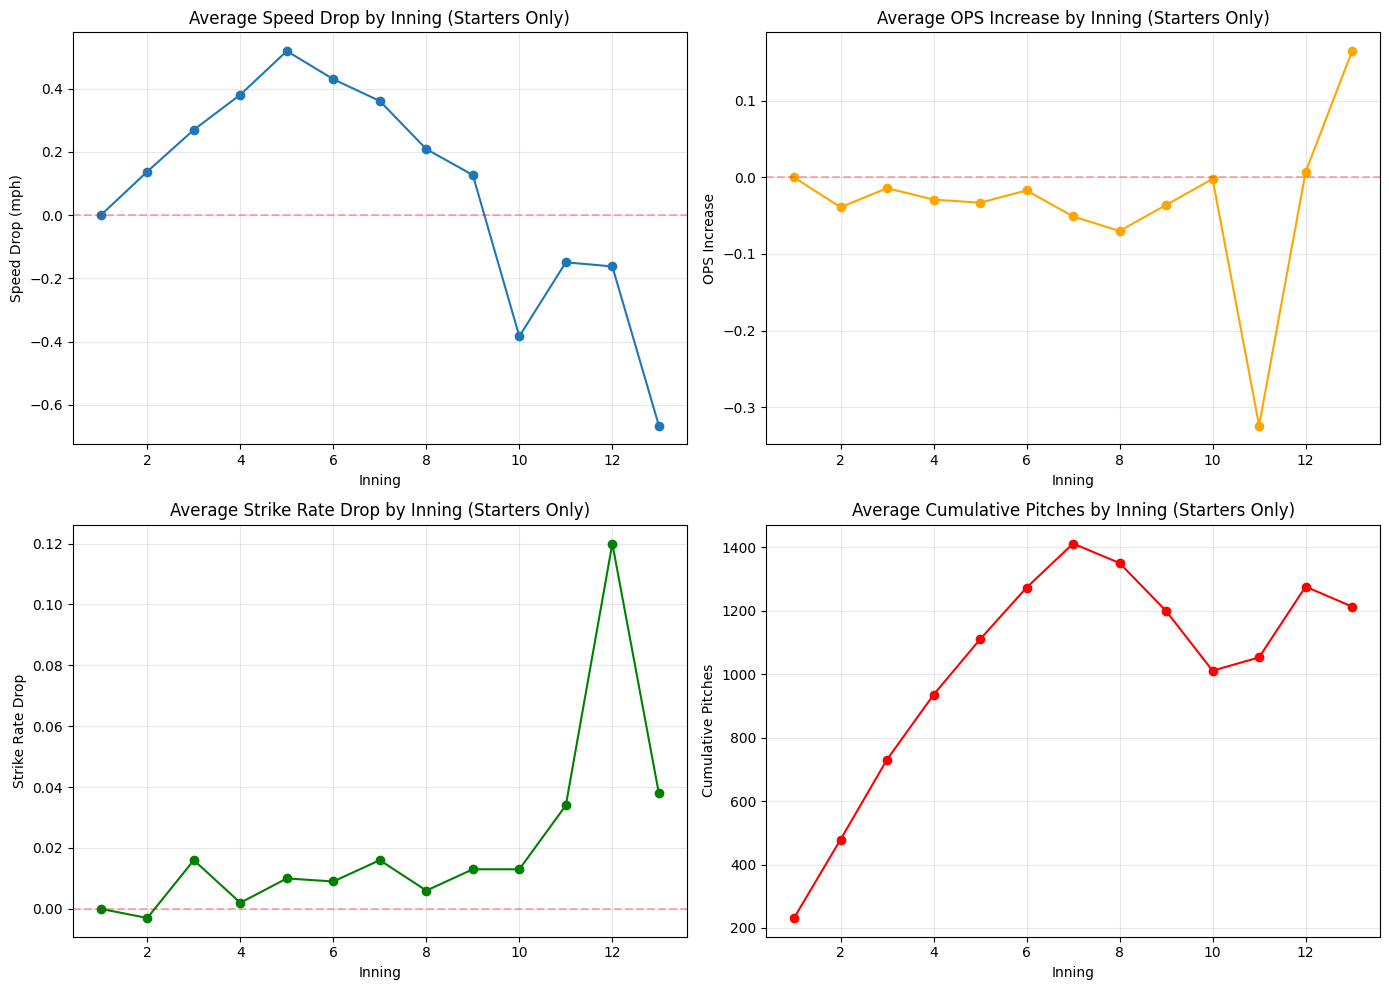

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].plot(fatigue_by_inning_starters.index, fatigue_by_inning_starters['speed_drop'], marker='o')
axes[0, 0].set_title('Average Speed Drop by Inning (Starters Only)')
axes[0, 0].set_xlabel('Inning')
axes[0, 0].set_ylabel('Speed Drop (mph)')
axes[0, 0].axhline(y=0, color='r', linestyle='--', alpha=0.3)
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(fatigue_by_inning_starters.index, fatigue_by_inning_starters['ops_increase'], marker='o', color='orange')
axes[0, 1].set_title('Average OPS Increase by Inning (Starters Only)')
axes[0, 1].set_xlabel('Inning')
axes[0, 1].set_ylabel('OPS Increase')
axes[0, 1].axhline(y=0, color='r', linestyle='--', alpha=0.3)
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].plot(fatigue_by_inning_starters.index, fatigue_by_inning_starters['strike_rate_drop'], marker='o', color='green')
axes[1, 0].set_title('Average Strike Rate Drop by Inning (Starters Only)')
axes[1, 0].set_xlabel('Inning')
axes[1, 0].set_ylabel('Strike Rate Drop')
axes[1, 0].axhline(y=0, color='r', linestyle='--', alpha=0.3)
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(fatigue_by_inning_starters.index, fatigue_by_inning_starters['cumulative_pitches'], marker='o', color='red')
axes[1, 1].set_title('Average Cumulative Pitches by Inning (Starters Only)')
axes[1, 1].set_xlabel('Inning')
axes[1, 1].set_ylabel('Cumulative Pitches')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [5]:
print("=== Sample Size by Inning ===")
sample_size = df_starters.groupby('inning').size()
print(sample_size)

=== Sample Size by Inning ===
inning
1     88048
2     88280
3     86939
4     82223
5     72028
6     46220
7     24496
8     17189
9      5819
10      140
11       76
12       10
13        3
14        2
15        1
dtype: int64


In [6]:
# 1-8イニングのみでモデル作成
df_model = df_starters[df_starters['inning'] <= 8].copy()

print(f"Model dataset size: {df_model.shape[0]}")

Model dataset size: 505423


In [7]:
fatigue_by_inning_clean = df_model.groupby('inning').agg({
    'speed_drop': 'mean',
    'spin_drop': 'mean',
    'ops_increase': 'mean',
    'strike_rate_drop': 'mean',
    'cumulative_pitches': 'mean'
}).round(3)

In [8]:
print("\n=== Fatigue Indicators by Inning (1-8 innings) ===")
print(fatigue_by_inning_clean)


=== Fatigue Indicators by Inning (1-8 innings) ===
        speed_drop  spin_drop  ops_increase  strike_rate_drop  \
inning                                                          
1            0.000     -0.000         0.000             0.000   
2            0.152     -1.084        -0.066            -0.006   
3            0.245     -3.041        -0.011             0.012   
4            0.433      3.163        -0.009             0.007   
5            0.626      6.385         0.021             0.012   
6            0.463     11.276         0.064             0.016   
7            0.348     12.816        -0.002             0.018   
8            0.158     19.611        -0.112             0.013   

        cumulative_pitches  
inning                      
1                   203.22  
2                  568.696  
3                  920.818  
4                  1248.31  
5                 1492.774  
6                 1319.083  
7                  520.391  
8                  224.935  


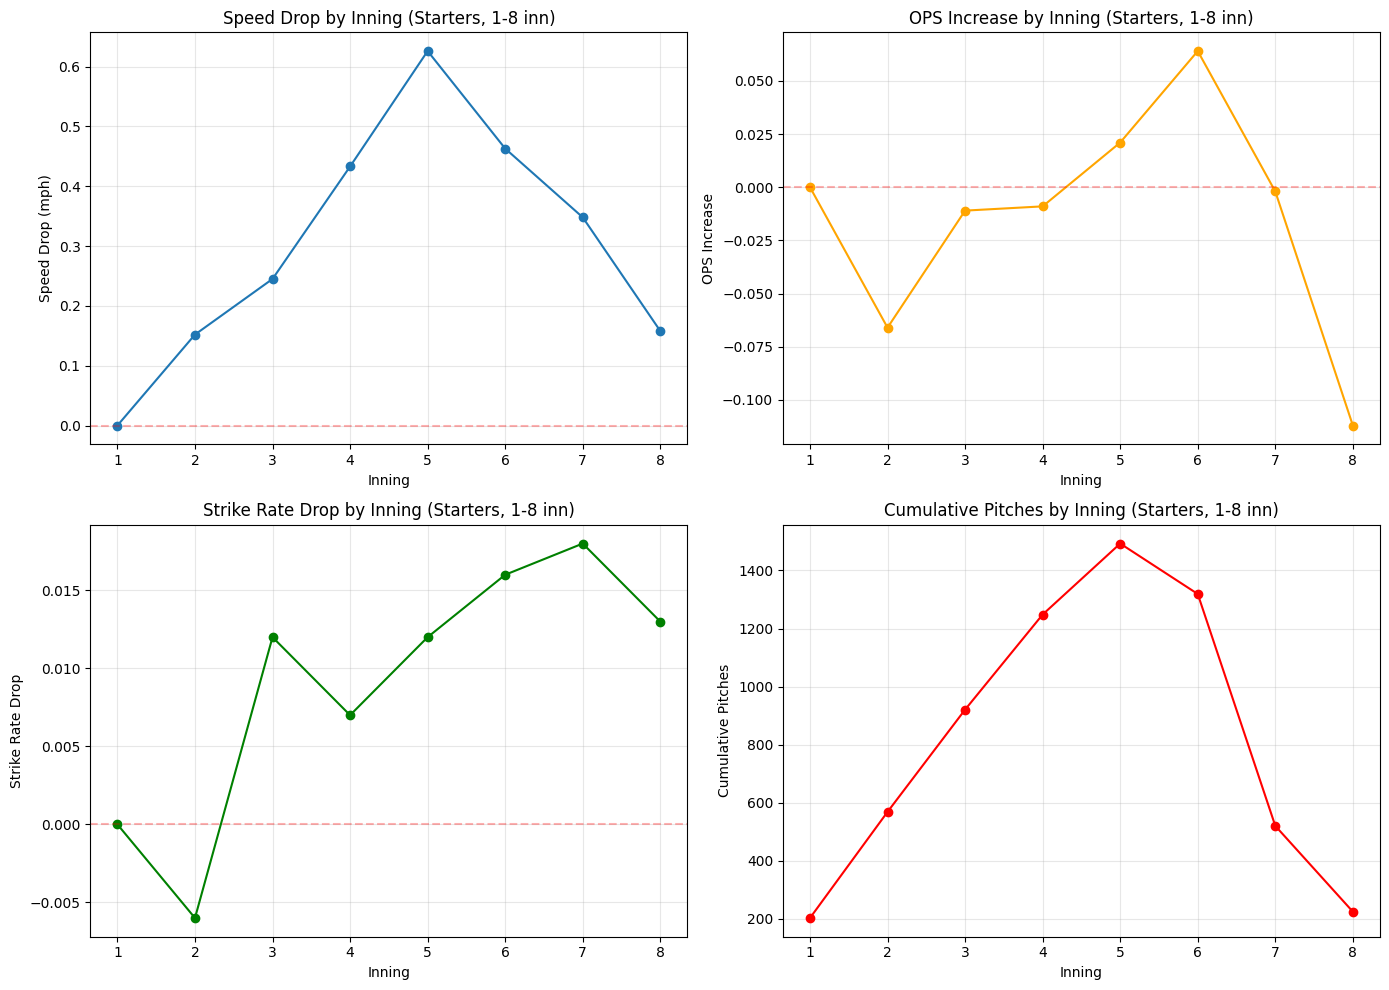

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].plot(fatigue_by_inning_clean.index, fatigue_by_inning_clean['speed_drop'], marker='o')
axes[0, 0].set_title('Speed Drop by Inning (Starters, 1-8 inn)')
axes[0, 0].set_xlabel('Inning')
axes[0, 0].set_ylabel('Speed Drop (mph)')
axes[0, 0].axhline(y=0, color='r', linestyle='--', alpha=0.3)
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(fatigue_by_inning_clean.index, fatigue_by_inning_clean['ops_increase'], marker='o', color='orange')
axes[0, 1].set_title('OPS Increase by Inning (Starters, 1-8 inn)')
axes[0, 1].set_xlabel('Inning')
axes[0, 1].set_ylabel('OPS Increase')
axes[0, 1].axhline(y=0, color='r', linestyle='--', alpha=0.3)
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].plot(fatigue_by_inning_clean.index, fatigue_by_inning_clean['strike_rate_drop'], marker='o', color='green')
axes[1, 0].set_title('Strike Rate Drop by Inning (Starters, 1-8 inn)')
axes[1, 0].set_xlabel('Inning')
axes[1, 0].set_ylabel('Strike Rate Drop')
axes[1, 0].axhline(y=0, color='r', linestyle='--', alpha=0.3)
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(fatigue_by_inning_clean.index, fatigue_by_inning_clean['cumulative_pitches'], marker='o', color='red')
axes[1, 1].set_title('Cumulative Pitches by Inning (Starters, 1-8 inn)')
axes[1, 1].set_xlabel('Inning')
axes[1, 1].set_ylabel('Cumulative Pitches')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [10]:
# ML modeling to predict timing for pitcher change based on fatigue indicators

# Target variable: ops_spike
df_model['next_inning_ops'] = df_model.groupby('pitcher_id')['ops_against'].shift(-1)
df_model['ops_spike'] = (df_model['next_inning_ops'] - df_model['ops_against']) > 0.15

In [11]:
# Drop inning 8 data since we can't observe next inning
df_model_train = df_model[df_model['inning'] < 8].dropna(subset=['ops_spike'])

In [12]:
print(f"Training dataset size: {df_model_train.shape[0]}")
if len(df_model_train) > 0:
    print(f"Fatigue spike rate: {df_model_train['ops_spike'].mean():.1%}")

Training dataset size: 488234
Fatigue spike rate: 39.7%


In [13]:
features = ['inning', 'speed_drop', 'cumulative_pitches', 'strike_rate_drop', 'ops_increase', 
            'fastball_speed', 'strike_rate', 'ball_rate']

X = df_model_train[features]
y = df_model_train['ops_spike'].astype(int)

In [14]:
X.head()

,inning,speed_drop,cumulative_pitches,strike_rate_drop,ops_increase,fastball_speed,strike_rate,ball_rate
0,1,1.268621,224.568966,-0.04931,0.424667,92.52,0.571,0.214
1,1,1.268621,224.568966,-0.04931,0.907667,92.52,0.571,0.214
2,1,1.268621,224.568966,-0.04931,-0.492333,92.52,0.571,0.214
3,1,1.268621,224.568966,-0.04931,-0.092333,92.52,0.571,0.214
4,1,1.268621,224.568966,-0.04931,-0.492333,92.52,0.571,0.214


In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

In [16]:
X_clean = X.replace([np.inf, -np.inf], np.nan).dropna()
y_clean = y.loc[X_clean.index]

In [17]:
print(f"Clean data size: {X_clean.shape[0]}")
if len(y_clean) > 0:
    print(f"Fatigue spike distribution:\n{y_clean.value_counts()}")

Clean data size: 480323
Fatigue spike distribution:
ops_spike
0    288964
1    191359
Name: count, dtype: int64


In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.2, random_state=42, stratify=y_clean)

In [19]:
# Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [20]:
# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, class_weight='balanced', n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [21]:
# Predictions
y_pred = rf_model.predict(X_test_scaled)
y_pred_proba = rf_model.predict_proba(X_test_scaled)[:, 1]

In [22]:
# Evaluation
print("\n=== Model Performance ===")
print(classification_report(y_test, y_pred))
print(f"\nROC AUC Score: {roc_auc_score(y_test, y_pred_proba):.3f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


=== Model Performance ===
              precision    recall  f1-score   support

           0       0.82      0.59      0.69     57793
           1       0.57      0.81      0.67     38272

    accuracy                           0.68     96065
   macro avg       0.70      0.70      0.68     96065
weighted avg       0.72      0.68      0.68     96065


ROC AUC Score: 0.761
Confusion Matrix:
[[34280 23513]
 [ 7358 30914]]


In [23]:
# Feature Importance
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n=== Feature Importance ===")
print(feature_importance)


=== Feature Importance ===
              feature  importance
4        ops_increase    0.949587
2  cumulative_pitches    0.012993
5      fastball_speed    0.008544
1          speed_drop    0.006967
3    strike_rate_drop    0.006558
0              inning    0.005911
6         strike_rate    0.004814
7           ball_rate    0.004625


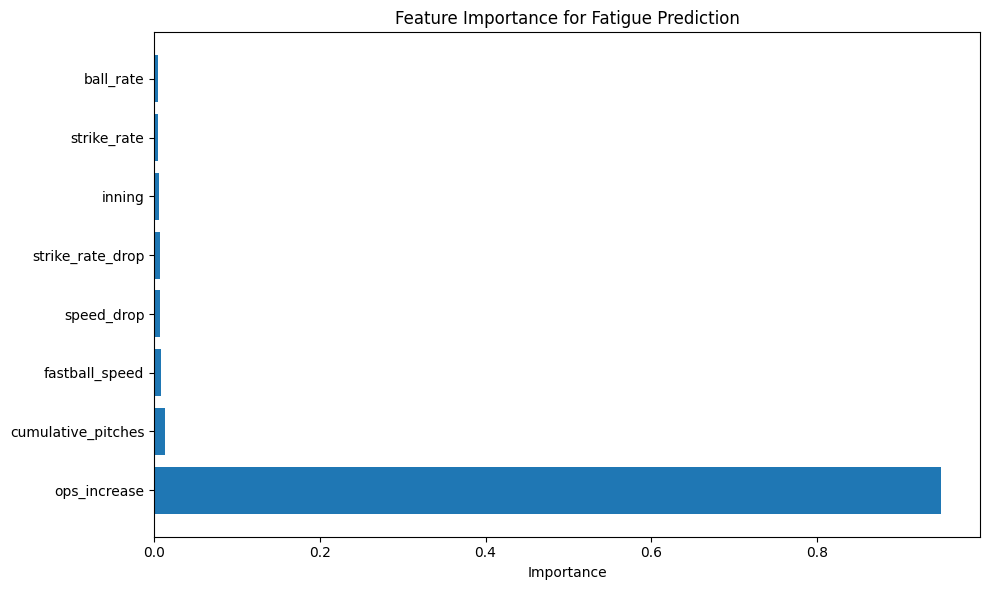

In [24]:
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Importance')
plt.title('Feature Importance for Fatigue Prediction')
plt.tight_layout()
plt.show()

In [25]:
threshold = 0.3
y_pred_adjusted = (y_pred_proba > threshold).astype(int)

print(f"=== Adjusted Performance (threshold={threshold}) ===")
print(classification_report(y_test, y_pred_adjusted))
print(f"\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_adjusted))

=== Adjusted Performance (threshold=0.3) ===
              precision    recall  f1-score   support

           0       0.90      0.39      0.54     57793
           1       0.50      0.94      0.66     38272

    accuracy                           0.61     96065
   macro avg       0.70      0.66      0.60     96065
weighted avg       0.74      0.61      0.59     96065


Confusion Matrix:
[[22440 35353]
 [ 2367 35905]]


In [26]:
import joblib
import os

In [27]:
model_dir = '../backend/app/models'
os.makedirs(model_dir, exist_ok=True)

In [48]:
# モデルとスケーラーを保存
joblib.dump(rf_model, os.path.join(model_dir, 'pitcher_fatigue_model.pkl'))
joblib.dump(scaler, os.path.join(model_dir, 'pitcher_fatigue_scaler.pkl'))

print("Model and scaler saved successfully!")
print(f"Model path: {os.path.join(model_dir, 'pitcher_fatigue_model.pkl')}")
print(f"Scaler path: {os.path.join(model_dir, 'pitcher_fatigue_scaler.pkl')}")

Model and scaler saved successfully!
Model path: ../backend/app/models\pitcher_fatigue_model.pkl
Scaler path: ../backend/app/models\pitcher_fatigue_scaler.pkl


In [49]:
# 特徴量リストも保存
features_list = ['inning', 'speed_drop', 'cumulative_pitches', 'strike_rate_drop', 'ops_increase', 
                 'fastball_speed', 'strike_rate', 'ball_rate']
joblib.dump(features_list, os.path.join(model_dir, 'pitcher_fatigue_features.pkl'))
print(f"Features list saved: {features_list}")

Features list saved: ['inning', 'speed_drop', 'cumulative_pitches', 'strike_rate_drop', 'ops_increase', 'fastball_speed', 'strike_rate', 'ball_rate']
